<a href="https://colab.research.google.com/github/kcbharat100/covid-19-detection-using-x-rays/blob/master/covid_19_detection_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Accessing dataset from github repo

!git clone https://github.com/kcbharat100/covid-19-detection-using-x-rays.git

Cloning into 'covid-19-detection-using-x-rays'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 3176 (delta 11), reused 9 (delta 1), pack-reused 3146
Receiving objects: 100% (3176/3176), 916.97 MiB | 15.24 MiB/s, done.
Resolving deltas: 100% (42/42), done.
Checking out files: 100% (1922/1922), done.


In [2]:
# Preparing balanced dataset
# Since there are 206 covid images, we are going to use 206 normal images 

import os
import shutil
import random

random.seed(123)
       
def get_file_list(input_dir):
    return [file for file in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, file))]

def get_random_files(file_list, N):
    return random.sample(file_list, N)

def copy_files(random_files, input_dir, output_dir):
    for file in random_files:
        shutil.copy(os.path.join(input_dir, file), output_dir)

def select_copy_randomly(input_dir, output_dir, N):
    file_list = get_file_list(input_dir)
    random_files = get_random_files(file_list, N)
    copy_files(random_files, input_dir, output_dir)

def copy_directory_files(input_dir, output_dir):
    files = get_file_list(input_dir)
    copy_files(files, input_dir, output_dir)

def file_count(dir):
  path, dirs, files = next(os.walk(dir))
  return len(files)

input_dir_normal = 'covid-19-detection-using-x-rays/dataset_binary/normal'
input_dir_covid = 'covid-19-detection-using-x-rays/dataset_binary/covid'
output_dir_normal = 'dataset/normal'
output_dir_covid = 'dataset/covid'

if not os.path.exists(output_dir_normal):
    os.makedirs(output_dir_normal)
if not os.path.exists(output_dir_covid):
    os.makedirs(output_dir_covid)
    
#select and copy randomly 206 images from github dataset to new directory- dataset
select_copy_randomly(input_dir_normal, output_dir_normal, 206)
print("Normal files count:")
print(str(file_count(output_dir_normal)))

#copy all 206 images from imported github dataset to new directory - dataset
copy_directory_files(input_dir_covid, output_dir_covid )
print("Covid files count:")
print(str(file_count(output_dir_covid)))
print('Done!')

Normal files count:
206
Covid files count:
206
Done!


In [3]:
# Splitting for train, validation and test

!pip install split-folders
import split_folders

split_folders.ratio('dataset', output="data", seed=123, ratio=(0.6, 0.2, 0.2)) # for train, test & test

Copying files: 412 files [00:00, 915.67 files/s]


In [4]:
# IMPORTING PACKAGES:

import os
import PIL
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Activation, Flatten, Dense
from keras import optimizers
from keras.applications import VGG19
from keras import Model
import tensorflow
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [ ]:
# Data preparation

# For reproducibility
tensorflow.random.set_seed(123)

train_dir = 'data/train'
validation_dir = 'data/val'
test_dir = 'data/test'

img_size = (224,224)  #as per the input image size of vgg19
batch_size = 32

classes = sorted(os.listdir(train_dir))
print(classes)

print("Getting data...")
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.25,
    # width_shift_range=0.2,
	  # height_shift_range=0.2,
    fill_mode="nearest"
    )

validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

print("Preparing trainig dataset...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    shuffle = True)

print("Preparing validation dataset...")
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = img_size,
    batch_size = batch_size,
    shuffle = True)

print("Preparing test dataset...")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    shuffle = False)

['covid', 'normal']
Getting data...
Preparing trainig dataset...
Found 246 images belonging to 2 classes.
Preparing validation dataset...
Found 82 images belonging to 2 classes.
Preparing test dataset...
Found 84 images belonging to 2 classes.


In [ ]:
# Transfer learning using pre trained model vgg19

# Load the base model, not including its final connected layer, and set the input shape to match our images
base_model = VGG19(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False
    
# Create layers for classification of our images
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.25)(x)
prediction_layer = Dense(2, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
opt = optimizers.Adam(lr = 1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

# View trainable layers 
for layer in model.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))

print(model.summary())

False:	input_5
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_conv4
False:	block5_pool
True:	flatten_6
True:	dense_11
True:	dropout_6
True:	dense_12
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_____________________________

In [ ]:
# Training:
num_epochs = 20

# checkpoint = keras.callbacks.ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', 
# 							monitor='val_acc', verbose=1, 
# 							save_best_only=True, mode='auto')

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs,
    callbacks= [earlyStopping])
    # callbacks= [checkpoint, earlyStopping])


Epoch 1/20
7/7 [==============================] - 10s 1s/step - loss: 0.6604 - acc: 0.6215 - val_loss: 0.4784 - val_acc: 0.7344
Epoch 2/20
7/7 [==============================] - 10s 1s/step - loss: 0.4939 - acc: 0.7757 - val_loss: 0.3259 - val_acc: 0.9600
Epoch 3/20
7/7 [==============================] - 8s 1s/step - loss: 0.3546 - acc: 0.8925 - val_loss: 0.2840 - val_acc: 0.9400
Epoch 4/20
7/7 [==============================] - 9s 1s/step - loss: 0.2794 - acc: 0.9299 - val_loss: 0.2069 - val_acc: 0.9375
Epoch 5/20
7/7 [==============================] - 10s 1s/step - loss: 0.2160 - acc: 0.9554 - val_loss: 0.1609 - val_acc: 0.9600
Epoch 6/20
7/7 [==============================] - 7s 1s/step - loss: 0.1886 - acc: 0.9486 - val_loss: 0.0839 - val_acc: 0.9800
Epoch 7/20
7/7 [==============================] - 9s 1s/step - loss: 0.1605 - acc: 0.9766 - val_loss: 0.1315 - val_acc: 0.9688
Epoch 8/20
7/7 [==============================] - 9s 1s/step - loss: 0.1307 - acc: 0.9766 - val_loss: 0.0819

In [ ]:
# Evalution:

_, acc = model.evaluate_generator(train_generator, steps=train_generator.samples//batch_size +1, verbose = 0)
print('Train Accuracy: %.2f' % (acc * 100.0))

_, acc = model.evaluate_generator(validation_generator, steps=test_generator.samples//batch_size +1, verbose = 0)
print('Validation Accuracy: %.2f' % (acc * 100.0))

_, acc = model.evaluate_generator(test_generator, steps=test_generator.samples//batch_size +1, verbose = 0)
print('Test Accuracy: %.2f' % (acc * 100.0))

Train Accuracy: 98.78
Validation Accuracy: 100.00
Test Accuracy: 98.81


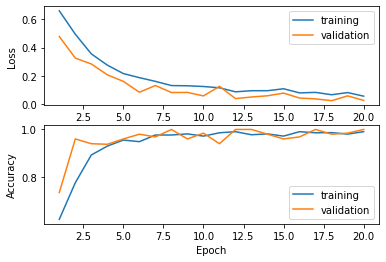

In [ ]:
# Loss and Accuray history

%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.figure(1)
plt.subplot(211)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc='upper right')

epoch_nums = range(1,num_epochs+1)
training_accuracy = history.history["acc"]
validation_accuracy = history.history["val_acc"]
plt.subplot(212)
plt.plot(epoch_nums, training_accuracy)
plt.plot(epoch_nums, validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

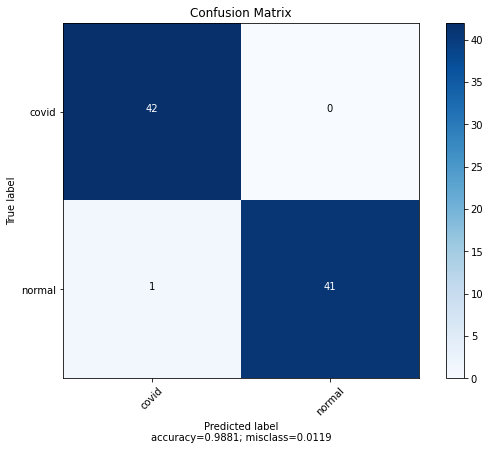

Classification Report:
              precision    recall  f1-score   support

       covid       0.98      1.00      0.99        42
      normal       1.00      0.98      0.99        42

    accuracy                           0.99        84
   macro avg       0.99      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84



In [ ]:
# Confusion matrix and classification report

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

test_steps_per_epoch = np.ceil(test_generator.samples/test_generator.batch_size)
Predictions = model.predict_generator(test_generator, steps= test_steps_per_epoch, verbose=0)
predictions = Predictions.argmax(axis=1)
test_labels = test_generator.classes
cm = confusion_matrix(test_labels, predictions)
cm_plot_labels = list(train_generator.class_indices)
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

print('Classification Report:')
target_names = list(train_generator.class_indices)
print(classification_report(test_generator.classes, predictions, target_names=target_names))

In [ ]:
# Fine tuning using pretrained model vgg19

train_generator.reset();
validation_generator.reset();

for layer in base_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name)
    # Set the layer's bool.
    layer.trainable = trainable
    
# Create layers for classification of our images
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
prediction_layer = Dense(2, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
opt = optimizers.Adam(lr = 1e-5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

# View trainable layers 
for layer in model.layers:
  print("{0}:\t{1}".format(layer.trainable, layer.name))

print(model.summary())

False:	input_5
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_conv4
True:	block5_pool
True:	flatten_9
True:	dense_17
True:	dropout_9
True:	dense_18
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
__________________________________

In [ ]:
# Training
num_epochs = 15

# checkpoint = keras.callbacks.ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', 
# 							monitor='val_acc', verbose=1, 
# 							save_best_only=True, mode='auto')

earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

history_fine = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs,
    callbacks= [earlyStopping])
    # callbacks= [checkpoint, earlyStopping])


Epoch 1/15
7/7 [==============================] - 10s 1s/step - loss: 0.4985 - acc: 0.7336 - val_loss: 0.1410 - val_acc: 1.0000
Epoch 2/15
7/7 [==============================] - 10s 1s/step - loss: 0.1421 - acc: 0.9579 - val_loss: 0.0659 - val_acc: 0.9400
Epoch 3/15
7/7 [==============================] - 8s 1s/step - loss: 0.0926 - acc: 0.9866 - val_loss: 0.0673 - val_acc: 0.9800
Epoch 4/15
7/7 [==============================] - 9s 1s/step - loss: 0.0396 - acc: 0.9907 - val_loss: 0.0094 - val_acc: 1.0000
Epoch 5/15
7/7 [==============================] - 9s 1s/step - loss: 0.0574 - acc: 0.9860 - val_loss: 0.0065 - val_acc: 1.0000
Epoch 6/15
7/7 [==============================] - 8s 1s/step - loss: 0.0286 - acc: 0.9953 - val_loss: 0.0413 - val_acc: 1.0000
Epoch 7/15
7/7 [==============================] - 9s 1s/step - loss: 0.0112 - acc: 1.0000 - val_loss: 0.0148 - val_acc: 1.0000
Epoch 8/15
7/7 [==============================] - 9s 1s/step - loss: 0.0186 - acc: 0.9953 - val_loss: 0.0251 

In [ ]:
# Evalution

_, acc = model.evaluate_generator(train_generator, steps=train_generator.samples//batch_size +1, verbose = 1)
print('Train Accuracy: %.2f' % (acc * 100.0))

_, acc = model.evaluate_generator(validation_generator, steps=validation_generator.samples//batch_size +1, verbose = 1)
print('Validation Accuracy: %.2f' % (acc * 100.0))

_, acc = model.evaluate_generator(test_generator, steps=test_generator.samples//batch_size +1, verbose = 1)
print('Test Accuracy: %.2f' % (acc * 100.0))


8/8 [==============================] - 9s 1s/step
Train Accuracy: 100.00
3/3 [==============================] - 3s 962ms/step
Validation Accuracy: 98.78
3/3 [==============================] - 3s 846ms/step
Test Accuracy: 98.81


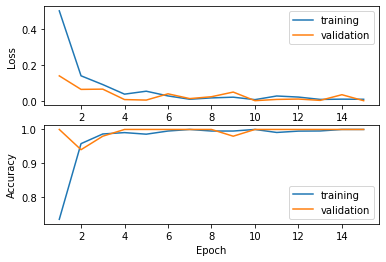

In [ ]:
# Loss and Accuracy history

%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history_fine.history["loss"]
validation_loss = history_fine.history["val_loss"]
plt.figure(1)
plt.subplot(211)
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc='upper right')

epoch_nums = range(1,num_epochs+1)
training_accuracy = history_fine.history["acc"]
validation_accuracy = history_fine.history["val_acc"]
plt.subplot(212)
plt.plot(epoch_nums, training_accuracy)
plt.plot(epoch_nums, validation_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

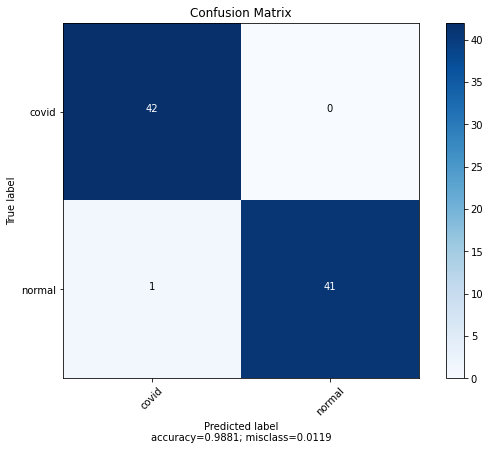

Classification Report:
              precision    recall  f1-score   support

       covid       0.98      1.00      0.99        42
      normal       1.00      0.98      0.99        42

    accuracy                           0.99        84
   macro avg       0.99      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84



In [ ]:
# Confusion matrix and classification report

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

test_steps_per_epoch = np.ceil(test_generator.samples/test_generator.batch_size)
Predictions = model.predict_generator(test_generator, steps= test_steps_per_epoch, verbose=0)
predictions = Predictions.argmax(axis=1)
test_labels = test_generator.classes
cm = confusion_matrix(test_labels, predictions)
cm_plot_labels = list(train_generator.class_indices)
plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

print('Classification Report:')
target_names = list(train_generator.class_indices)
print(classification_report(test_generator.classes, predictions, target_names=target_names))

In [ ]:
model.save('model_covid')

In [ ]:
#Converting keras h5 model into mobile friendly tflite model
import tensorflow as tf

tflite_model = tf.keras.models.load_model('model_covid')
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_save = converter.convert()
open('model_covid_tflite.tflite', "wb").write(tflite_save)


32896784

In [ ]:
#Saving model

import tensorflow as tf

model.save('model_covid_binary.hdf5')

model = tf.keras.models.load_model('model_covid_binary.hdf5')

# Save the model.
export_dir = "/tmp/test_saved_model"
tf.saved_model.save(model, export_dir)

#Converting keras model into tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = 'converted_model_covid_binary.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/test_saved_model/assets


INFO:tensorflow:Assets written to: /tmp/test_saved_model/assets


In [ ]:
# Class labels
from google.colab import files

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)
  
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Downloading test folder
from google.colab import files

shutil.make_archive('data/test', 'zip', 'data/test')
files.download('data/test.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The list of classes:  ['covid', 'normal']
Number of errors = 1/84


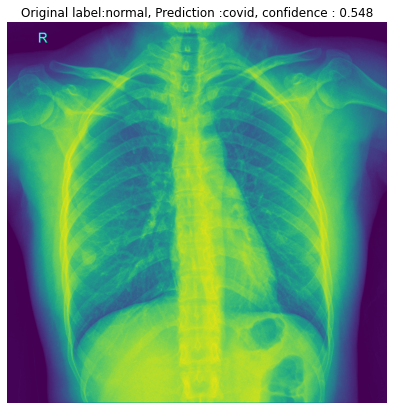

In [ ]:
#Seeing mispredicted images

import matplotlib.image as mpimg

# Utility function for obtaining of the errors 

def obtain_errors(test_gen, predictions):
    # Get the filenames from the generator
    fnames = test_gen.filenames

    # Get the ground truth from generator
    ground_truth = test_gen.classes

    # Get the dictionary of classes
    label2index = test_gen.class_indices

    # Obtain the list of the classes
    idx2label = list(label2index.keys())
    print("The list of classes: ", idx2label)

    # Get the class index
    predicted_classes = np.argmax(predictions, axis=1)

    errors = np.where(predicted_classes != ground_truth)[0]
    print("Number of errors = {}/{}".format(len(errors),test_gen.samples))
    
    return idx2label, errors, fnames


# Utility function for visualization of the errors
def show_errors(idx2label, errors, predictions, fnames, directory):
    # Show the errors
    for i in range(len(errors)):
        pred_class = np.argmax(predictions[errors[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[errors[i]].split('/')[0],
            pred_label,
            predictions[errors[i]][pred_class])

        # original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
        img = mpimg.imread('{}/{}'.format(directory,fnames[errors[i]]))
        
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        # plt.imshow(original)
        plt.imshow(img) 
        plt.show()


# Get the predictions from the model using the generator
predictions = model.predict(test_generator, steps= test_steps_per_epoch)

dir = test_dir

# Run the function to get the list of classes and errors
idx2label, errors, fnames = obtain_errors(test_generator, predictions)

# Run the function to illustrate the error cases
show_errors(idx2label, errors, predictions, fnames, dir)